# **Advanced DNN with Callbacks and Adaptive Learning Rate**

*Objective: Develop an advanced DNN with sophisticated features such as callbacks and adaptive learning rates for enhanced performance and stability*

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding,
    LSTM,
    GRU,
    Dense,
    Bidirectional,
    Input,
    Attention,
    Layer
)
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np


## **Load Dataset and Data Preprocessing**

In [ ]:
# Parameters
vocab_size = 20000  # Only consider the top 20,000 words
max_sequence_length = 200  # Maximum review length in words

# Load the dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

print(f"Training samples: {len(x_train)}")
print(f"Testing samples: {len(x_test)}")

# Pad sequences to the same length
x_train_padded = pad_sequences(x_train, maxlen=max_sequence_length, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test, maxlen=max_sequence_length, padding='post', truncating='post')

print(f"Padded training shape: {x_train_padded.shape}")
print(f"Padded testing shape: {x_test_padded.shape}")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training data shape: (50000, 32, 32, 3), Training labels shape: (50000, 1)
Testing data shape: (10000, 32, 32, 3), Testing labels shape: (10000, 1)
y_train shape: (50000, 10)
y_test shape: (10000, 10)


In [ ]:
def build_base_model(vocab_size, max_sequence_length, embedding_dim=128, lstm_units=64):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
        LSTM(lstm_units),
        Dense(1, activation='sigmoid')
    ])
    return model

base_model = build_base_model(vocab_size, max_sequence_length)
base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
base_model.summary()


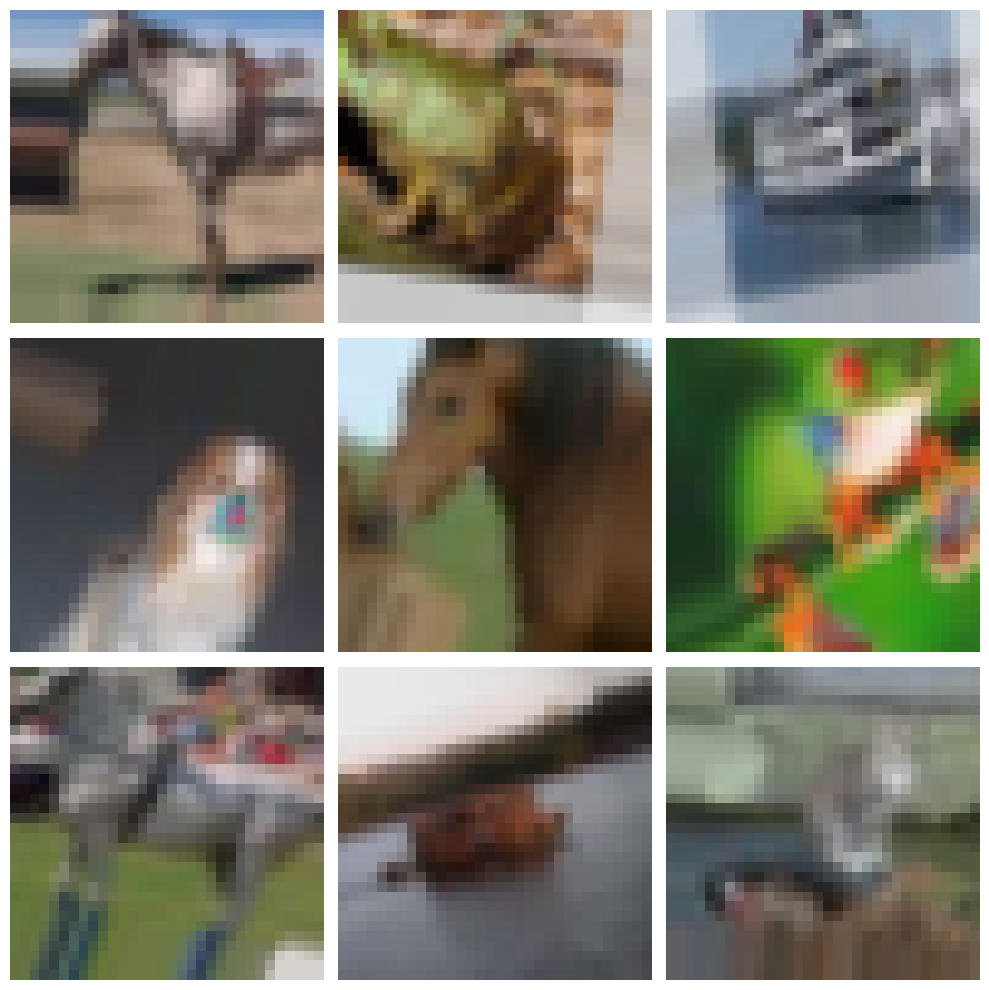

In [ ]:
def build_bidirectional_model(vocab_size, max_sequence_length, embedding_dim=128, lstm_units=64):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
        Bidirectional(LSTM(lstm_units)),
        Dense(1, activation='sigmoid')
    ])
    return model

bidirectional_model = build_bidirectional_model(vocab_size, max_sequence_length)
bidirectional_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bidirectional_model.summary()


In [ ]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)
        # Compute context vector
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

def build_attention_model(vocab_size, max_sequence_length, embedding_dim=128, lstm_units=64):
    inputs = Input(shape=(max_sequence_length,))
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(inputs)
    lstm_out = LSTM(lstm_units, return_sequences=True)(embedding)
    attention = AttentionLayer()(lstm_out)
    outputs = Dense(1, activation='sigmoid')(attention)
    model = Model(inputs=inputs, outputs=outputs)
    return model

attention_model = build_attention_model(vocab_size, max_sequence_length)
attention_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
attention_model.summary()

def build_bidirectional_attention_model(vocab_size, max_sequence_length, embedding_dim=128, lstm_units=64):
    inputs = Input(shape=(max_sequence_length,))
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(inputs)
    bidirectional_lstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding)
    attention = AttentionLayer()(bidirectional_lstm)
    outputs = Dense(1, activation='sigmoid')(attention)
    model = Model(inputs=inputs, outputs=outputs)
    return model

bidirectional_attention_model = build_bidirectional_attention_model(vocab_size, max_sequence_length)
bidirectional_attention_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bidirectional_attention_model.summary()



## **Network Architecture**

In [ ]:
# Common training parameters
batch_size = 128
epochs = 10
validation_split = 0.2
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Function to train a model
def train_model(model, x_train, y_train):
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=validation_split,
        callbacks=[early_stopping],
        verbose=2
    )
    return history

# Train all models
print("Training Base Model...")
base_history = train_model(base_model, x_train_padded, y_train)

print("\nTraining Bidirectional Model...")
bidirectional_history = train_model(bidirectional_model, x_train_padded, y_train)

print("\nTraining Attention Model...")
attention_history = train_model(attention_model, x_train_padded, y_train)

print("\nTraining Bidirectional Attention Model...")
bidirectional_attention_history = train_model(bidirectional_attention_model, x_train_padded, y_train)


In [ ]:
def get_callbacks(model_name):
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    checkpoint = callbacks.ModelCheckpoint(
        filepath=f'{model_name}.keras',
        monitor='val_loss',
        save_best_only=True
    )

    lr_reduce = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        verbose=1
    )

    return [early_stop, checkpoint, lr_reduce]

def compile_and_train(model, model_name, train_gen, val_gen, epochs=100):
    model.compile(
        optimizer=optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    cb = get_callbacks(model_name)

    start_time = time.time()

    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=cb,
        steps_per_epoch=len(train_gen),
        validation_steps=len(val_gen),
        verbose=1
    )

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time for {model_name}: {training_time:.2f} seconds")

    return history, training_time


## **Define Callbacks**

In [ ]:
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot histories
plot_history(base_history, "Base Model")
plot_history(bidirectional_history, "Bidirectional Model")
plot_history(attention_history, "Attention Model")
plot_history(bidirectional_attention_history, "Bidirectional Attention Model")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 17/625 ━━━━━━━━━━━━━━━━━━━━ 1:13:01 7s/step - accuracy: 0.1582 - loss: 2.8325

In [ ]:
def evaluate_model(model, x_test, y_test, model_name):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"{model_name} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return loss, accuracy

print("\nEvaluating Models on Test Data:")

base_loss, base_acc = evaluate_model(base_model, x_test_padded, y_test, "Base Model")
bidirectional_loss, bidirectional_acc = evaluate_model(bidirectional_model, x_test_padded, y_test, "Bidirectional Model")
attention_loss, attention_acc = evaluate_model(attention_model, x_test_padded, y_test, "Attention Model")
bidirectional_attention_loss, bidirectional_attention_acc = evaluate_model(bidirectional_attention_model, x_test_padded, y_test, "Bidirectional Attention Model")


In [ ]:
import pandas as pd

data = {
    'Model': [
        'Base Model',
        'Bidirectional Model',
        'Attention Model',
        'Bidirectional Attention Model'
    ],
    'Test Loss': [
        base_loss,
        bidirectional_loss,
        attention_loss,
        bidirectional_attention_loss
    ],
    'Test Accuracy': [
        base_acc,
        bidirectional_acc,
        attention_acc,
        bidirectional_attention_acc
    ]
}

results_df = pd.DataFrame(data)
print("\nPerformance Summary:")
print(results_df)
